In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


Reference:

Many thanks to Venelin Valkov for the great tutorial ([1], [2], [3]): 

[1] https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

[2] https://www.youtube.com/watch?v=Osj0Z6rwJB4

[3] https://www.youtube.com/watch?v=8N-nM3QW7O0&t=733s

https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

https://www.kaggle.com/vishalsiram50/fine-tuning-bert-88-accuracy

https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/#:~:text=%5BCLS%5D%20is%20a%20special%20classification,segment%20embeddings%20for%20each%20token.

In [2]:
!pip install transformers

In [3]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [4]:
# https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm
def clean_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [5]:
# https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [6]:
train['text'] = clean_text(train['text'])
test['text'] = clean_text(test['text'])

train['text']=train['text'].apply(lambda x : remove_URL(x))
test['text']=test['text'].apply(lambda x : remove_URL(x))

train['text']=train['text'].apply(lambda x : remove_html(x))
test['text']=test['text'].apply(lambda x : remove_html(x))

train['text']=train['text'].apply(lambda x: remove_emoji(x))
test['text']=test['text'].apply(lambda x: remove_emoji(x))

train['text']=train['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13 000 people receive wildfires evacuation ord...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


In [9]:
# https://www.kaggle.com/vishalsiram50/fine-tuning-bert-88-accuracy
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Remove stopwords 
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'


In [11]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'train target')

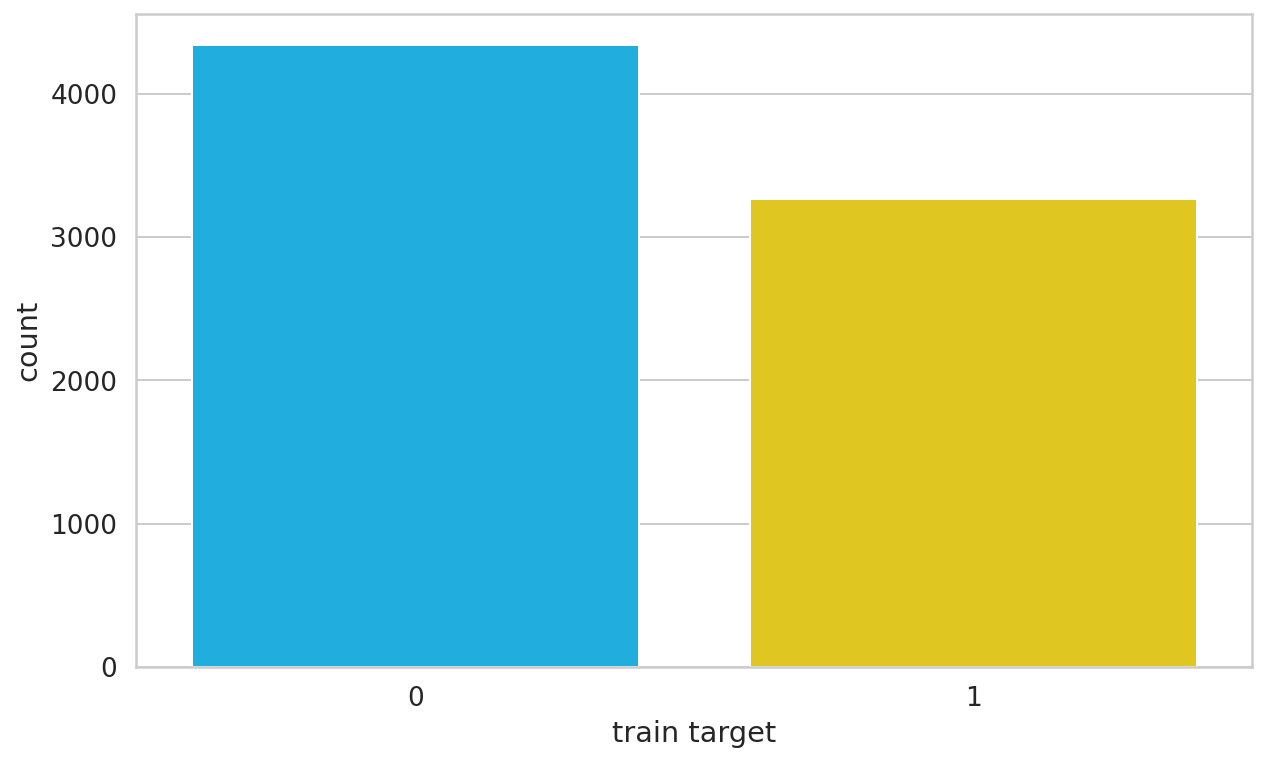

In [12]:
sns.countplot(train.target)
plt.xlabel('train target')

Bert Tokenizer: 
* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

Special Tokens:

[SEP] - marker for ending of a sentence

[CLS] - we must add this token to the start of each sentence, so BERT knows we’re doing classification

[PAD] - There is also a special token for padding

BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

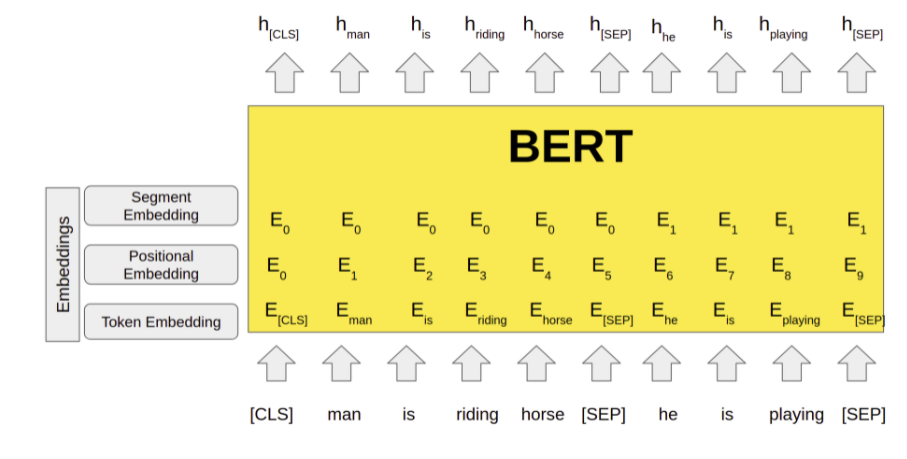

(https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/#:~:text=%5BCLS%5D%20is%20a%20special%20classification,segment%20embeddings%20for%20each%20token)

In [16]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [17]:
# All of that work can be done using the encode_plus() method
encoding = tokenizer.encode_plus(
  text=text_preprocessing(sample_txt),
  max_length=32,           # max length of sentence 
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
# The token ids are now stored in a Tensor and padded to a length of 32
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2197, 2648, 1029, 5881, 2188, 1016, 3134, 1012,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
# The attention mask has the same length:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
# We can inverse the tokenization to have a look at the special tokens
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'last', 'outside', '?', 'stuck', 'home', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [21]:
# Choosing max Sequence Length for our data set 
# BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.
all_tweets = np.concatenate([train.text.values, test.text.values])

token_lens = []
for txt in all_tweets:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

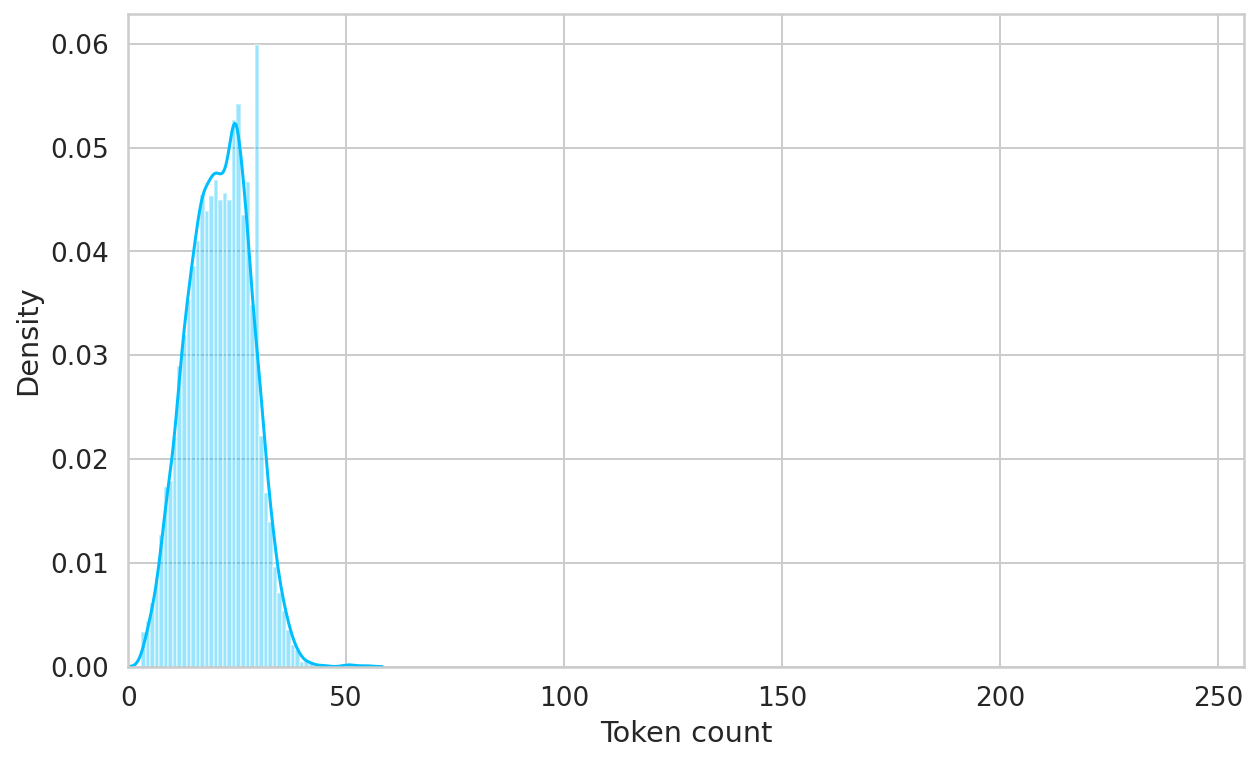

In [22]:
# plot the distribution
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [23]:
MAX_LEN = max(token_lens)
MAX_LEN

55

Create PyTorch dataset

In [24]:
class TweetDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.text)


  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      text=text_preprocessing(text),
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    
    
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [25]:
df_train, df_val = train_test_split(
  train,
  test_size=0.1,
  random_state=RANDOM_SEED
)

df_test = test
df_train.shape, df_val.shape, df_test.shape

((6851, 5), (762, 5), (3263, 4))

In [26]:
BATCH_SIZE = 16

In [27]:
def create_data_loader_train(df, tokenizer, max_len, batch_size):
  dataset = TweetDataset(
    text=df.text.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [28]:
class TweetDatasetTest(Dataset):
  def __init__(self, text, tokenizer, max_len):
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
    
  def __len__(self):
    return len(self.text)


  def __getitem__(self, item):
    text = str(self.text[item])
    encoding = self.tokenizer.encode_plus(
      text=text_preprocessing(text),
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    
    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten()
    }

In [29]:
def create_data_loader_test(df, tokenizer, max_len, batch_size):
  dataset = TweetDatasetTest(
    text=df.text.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2
  )

In [30]:
train_data_loader = create_data_loader_train(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader_train(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader_test(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [31]:
import warnings
warnings.filterwarnings("ignore")
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [32]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 55])
torch.Size([16, 55])
torch.Size([16])


Bert Model

In [33]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# return last state of encoder and pooled output 
# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state

# We have the hidden state for each of our 32 tokens (the length of our example sequence).
# 768 is the number of hidden units in the feedforward-networks

# https://huggingface.co/docs/transformers/model_doc/bert#bertmodel

# https://stackoverflow.com/questions/65132144/bertmodel-transformers-outputs-string-instead-of-tensor
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

print(type(output))
print(output.keys())
print(bert_model.config.hidden_size)


<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])
768


In [35]:
print(output['last_hidden_state'].shape)

torch.Size([1, 32, 768])


In [36]:
print(output['pooler_output'].shape)

torch.Size([1, 768])


Build Sentiment Classifier

In [37]:
import torch
import torch.nn as nn

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [38]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, p):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p)
    # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

    
  def forward(self, input_ids, attention_mask):
    output_dict = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output_dict['pooler_output'])
    output = self.out(output)
    return self.softmax(output)

In [39]:
N_CLASSES = 2
P = 0
model = SentimentClassifier(N_CLASSES, P)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
# data = next(iter(train_data_loader))
print(len(data['text']))
# data is consisted of 16 tweets 

16


In [41]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [42]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 55])
torch.Size([16, 55])


In [43]:
# inject input ids and attention mask into Sentiment Classifier 
# this returns the probablity for 0 or 1 for each tweet in data 
model(input_ids, attention_mask)

tensor([[0.4104, 0.5896],
        [0.3442, 0.6558],
        [0.5663, 0.4337],
        [0.4692, 0.5308],
        [0.3642, 0.6358],
        [0.3899, 0.6101],
        [0.4432, 0.5568],
        [0.4156, 0.5844],
        [0.5578, 0.4422],
        [0.3290, 0.6710],
        [0.4475, 0.5525],
        [0.5061, 0.4939],
        [0.4225, 0.5775],
        [0.3737, 0.6263],
        [0.3322, 0.6678],
        [0.4168, 0.5832]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Train Model 

To reproduce the training procedure from the BERT paper, we’ll use the AdamW optimizer provided by Hugging Face. 

It corrects weight decay, so it’s similar to the original paper. We’ll also use a linear scheduler with no warmup steps

In [44]:
EPOCHS = 15
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [45]:
def train_epoch(
      model,
      data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      n_examples
):
      model = model.train()
      losses = []
      correct_predictions = 0
        
      for data in data_loader:
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            # inject inputs ids and attention mask into bert model 
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )

            # return prediction 
            _, preds = torch.max(outputs, dim=1)

            # calculate loss 
            loss = loss_fn(outputs, targets)

            # calculate correct prediction 
            correct_predictions += torch.sum(preds == targets)
            
            # append each loss
            losses.append(loss.item())
            
            # back propagation 
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # updata parameters 
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
      return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things.

The scheduler gets called every time a batch is fed to the model. 

We’re avoiding exploding gradients by clipping the gradients of the model using clipgrad_norm.

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for data in data_loader:
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      targets = data["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
        
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
        
  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    train_acc, train_loss = train_epoch(
                            model,
                            train_data_loader,
                            loss_fn,
                            optimizer,
                            device,
                            scheduler,
                            len(df_train)
                        )
    
    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    val_acc, val_loss = eval_model(
                            model,
                            val_data_loader,
                            loss_fn,
                            device,
                            len(df_val)
                        )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/15
----------
Train loss 0.5359520230676744 accuracy 0.7765289738724274
Val   loss 0.5250041683514913 accuracy 0.7874015748031495

Epoch 2/15
----------
Train loss 0.5004392817859605 accuracy 0.8125821048022186
Val   loss 0.5227463158468405 accuracy 0.7900262467191601

Epoch 3/15
----------
Train loss 0.48800866455187053 accuracy 0.8249890526930375
Val   loss 0.5465632242461046 accuracy 0.7664041994750657

Epoch 4/15
----------
Train loss 0.476935361162488 accuracy 0.8357903955626915
Val   loss 0.5445150081068277 accuracy 0.7677165354330708

Epoch 5/15
----------
Train loss 0.46993693466230985 accuracy 0.8420668515545175
Val   loss 0.5105434320867062 accuracy 0.7992125984251969

Epoch 6/15
----------
Train loss 0.45127027372380235 accuracy 0.8606042913443293
Val   loss 0.511231079697609 accuracy 0.800524934383202

Epoch 7/15
----------
Train loss 0.44378553466363385 accuracy 0.8692161728214859
Val   loss 0.5048303982863823 accuracy 0.8057742782152231

Epoch 8/15
----------
Trai

(0.0, 1.0)

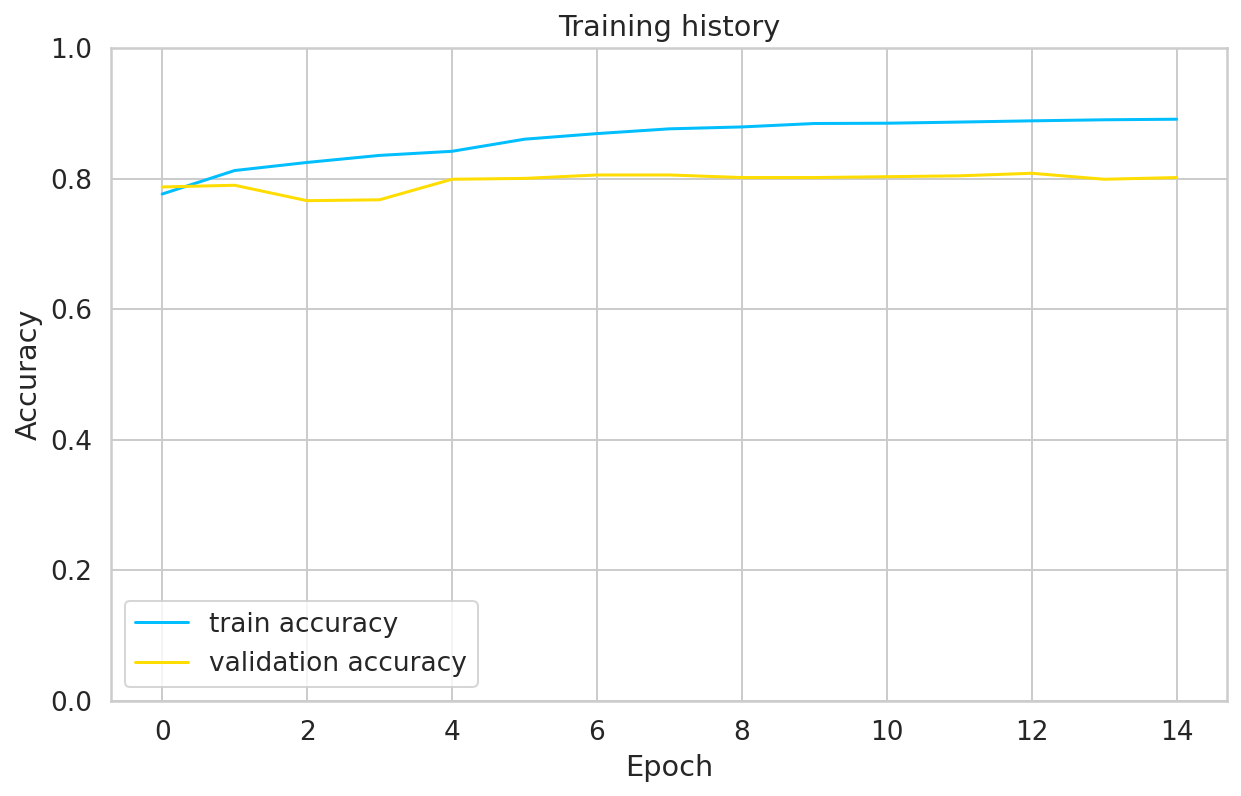

In [48]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

Predictions

In [49]:
test_data = next(iter(test_data_loader))
print(test_data['text'])

['just happened a terrible car crash', 'heard about earthquake is different cities stay safe everyone ', 'there is a forest fire at spot pond geese are fleeing across the street i cannot save them all', 'apocalypse lighting spokane wildfires', 'typhoon soudelor kills 28 in china and taiwan', 'were shaking its an earthquake', 'theyd probably still show more life than arsenal did yesterday eh eh', 'hey how are you', 'what a nice hat', 'fuck off', 'no i dont like cold', 'nooooooooo dont do that', 'no dont tell me that', 'what if', 'awesome', 'birmingham wholesale market is ablaze bbc news fire breaks out at birminghams wholesale market URL']


In [50]:
print(test_data['input_ids'])

tensor([[  101,  3047,  6659,  2482,  5823,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2657,  8372,  2367,  3655,  2994,  3647,  3071,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  3224,  2543,  3962,  8644, 28519, 14070,  2408,  2395,  3685,
          3828,   102,     0,     0,     

In [51]:
print(test_data['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0,

In [52]:
def get_predictions(model, data_loader):
  model = model.eval()
  tweets = []
  predictions = []
  prediction_probs = []
  
  with torch.no_grad():
    for data in data_loader:
      texts = data["text"]
      input_ids = data["input_ids"].to(device)
      attention_mask = data["attention_mask"].to(device)
      
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
    
      _, preds = torch.max(outputs, dim=1)
      tweets.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  
  return tweets, predictions, prediction_probs

In [53]:
_, y_pred, _ = get_predictions(model, test_data_loader)

In [54]:
print(len(y_pred.tolist()))

3263


In [55]:
submission['target'] = y_pred.tolist()
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [56]:
submission.to_csv('submission.csv', index=False)